# Exporting / Importing trained MaskRCNN model


In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import imageio
import tensorflow as tf
from tensorflow.python.framework import graph_util
from keras import backend as K

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the mrcnn library

#from sate import CocoConfig as Config - will require defining InferenceConfig yourself as a subclass of Config
from inference_config import InferenceConfig
import mrcnn.model as modellib
import mrcnn.utils as utils
import mrcnn.visualize as visualize
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline 

/home/ashwin/miniconda3/envs/dlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Exporting model
After retrain the model using train.py, we export the model 

In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)
# Directory to trained model
train_log_dirpath = os.getcwd()#os.path.join(ROOT_DIR, "logs")
print(train_log_dirpath)
model_filepath = os.path.join(ROOT_DIR, train_log_dirpath,"mask_rcnn_sate_spaceaug_0045.h5")
print(model_filepath)
# name of the pb file we want to output
filename = 'mrcnn_model.pb'

/home/ashwin/Desktop/SpaceNet/Mask_RCNN/samples/coco
/home/ashwin/Desktop/SpaceNet/Mask_RCNN/samples/coco/mask_rcnn_sate_spaceaug_0045.h5


In [4]:
# Display Inference Config
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [5]:
# Build the inference model
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=train_log_dirpath)
# Get path to saved weights. Either set a specific path or find last trained weights
model_filepath = model_filepath if model_filepath else model.find_last()[1]
#print(model_filepath)
# Load trained weights (fill in path to trained weights here)
assert model_filepath, "Provide path to trained weights"
model.load_weights(model_filepath, by_name=True)
print("Model loaded.")

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Model loaded.


In [6]:
# Get keras model and save
model_keras= model.keras_model
# All new operations will be in test mode from now on.
K.set_learning_phase(0)
# Create output layer with customized names
num_output = 7
pred_node_names = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask",
                       "rois", "rpn_class", "rpn_bbox"]
pred_node_names = ["output_" + name for name in pred_node_names]
print(pred_node_names)

['output_detections', 'output_mrcnn_class', 'output_mrcnn_bbox', 'output_mrcnn_mask', 'output_rois', 'output_rpn_class', 'output_rpn_bbox']


In [7]:
pred = [tf.identity(model_keras.outputs[i], name = pred_node_names[i])
        for i in range(num_output)]
sess = K.get_session()
# Get the object detection graph
od_graph_def = graph_util.convert_variables_to_constants(sess,
                                                         sess.graph.as_graph_def(),
                                                         pred_node_names)

INFO:tensorflow:Froze 690 variables.
INFO:tensorflow:Converted 690 variables to const ops.


In [8]:
model_dirpath = os.path.dirname(model_filepath)
pb_filepath = os.path.join(model_dirpath, filename)
print('Saving frozen graph {} ...'.format(os.path.basename(pb_filepath)))

frozen_graph_path = pb_filepath
with tf.gfile.GFile(frozen_graph_path, 'wb') as f:
    f.write(od_graph_def.SerializeToString())
print('{} ops in the frozen graph.'.format(len(od_graph_def.node)))
#print('pb file saved at', model_dirpath)

Saving frozen graph mrcnn_model.pb ...
2958 ops in the frozen graph.


# Importing model
Now, we can load the model from the pb file and then use it to run inference

In [9]:
# Specify path to the .pb file if exported model already present
#pb_filepath = "path/to/.pb file"

# Change detection confidence threshold if necessary
#inference_config.DETECTION_MIN_CONFIDENCE = 0.7

In [10]:
def compute_backbone_shapes(config, image_shape):
    """Computes the width and height of each stage of the backbone network.
    
    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def get_anchors(image_shape, config):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(config, image_shape)
    # Cache anchors and reuse if image shape is the same
    _anchor_cache = {}
    if not tuple(image_shape) in _anchor_cache:
        # Generate Anchors
        a = utils.generate_pyramid_anchors(
            config.RPN_ANCHOR_SCALES,
            config.RPN_ANCHOR_RATIOS,
            backbone_shapes,
            config.BACKBONE_STRIDES,
            config.RPN_ANCHOR_STRIDE)
        # Keep a copy of the latest anchors in pixel coordinates because
        # it's used in inspect_model notebooks.
        # TODO: Remove this after the notebook are refactored to not use it
        anchors = a
        # Normalize coordinates
        _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

def is_grey_scale(img_path):
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [11]:
def mold_inputs(images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matricies [height,width,depth]. Images can have
            different sizes.

        Returns 3 Numpy matricies:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image to fit the model expected size
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=inference_config.IMAGE_MIN_DIM,
                max_dim=inference_config.IMAGE_MAX_DIM,
                mode=inference_config.IMAGE_RESIZE_MODE)
            
            """Takes RGB images with 0-255 values and subtraces
                   the mean pixel and converts it to float. Expects image
                   colors in RGB order."""
            molded_image = mold_image(molded_image, inference_config)
        
            """Takes attributes of an image and puts them in one 1D array."""
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([inference_config.NUM_CLASSES], dtype=np.int32))
            
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

def mold_image(images, config):
    return images.astype(np.float32) - config.MEAN_PIXEL

def compose_image_meta(image_id, original_image_shape, image_shape, window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.

    image_id: An int ID of the image. Useful for debugging.
    image_shape: [height, width, channels]
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +            # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +     # size=3
        list(window) +          # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +
        list(active_class_ids)  # size=num_classes
    )
    return meta


def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.

        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.

        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]
            
        # Filter out detections below a certain confidence score
        exclude_ix2 = np.where(scores <= inference_config.DETECTION_MIN_CONFIDENCE)[0]
        if exclude_ix2.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix2, axis=0)
            class_ids = np.delete(class_ids, exclude_ix2, axis=0)
            scores = np.delete(scores, exclude_ix2, axis=0)
            masks = np.delete(masks, exclude_ix2, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

In [12]:
def detect(sess, images, inference_config, verbose=0):
    
    if verbose:
        modellib.log("Processing {} images".format(len(images)))
        for image in images:
            modellib.log("image", image)

    molded_images, image_metas, windows = mold_inputs(images)
    image_shape = molded_images[0].shape

    # Anchors
    anchors = get_anchors(image_shape, inference_config)
    # Duplicate across the batch dimension because Keras requires it
    # TODO: can this be optimized to avoid duplicating the anchors?
    inference_config.BATCH_SIZE = 1
    image_anchors = np.broadcast_to(anchors, (inference_config.BATCH_SIZE,) + anchors.shape)

    if verbose:
        modellib.log("molded_images", molded_images)
        modellib.log("image_metas", image_metas)
        modellib.log("anchors", anchors)

    img_ph = sess.graph.get_tensor_by_name('input_image:0')
    img_meta_ph = sess.graph.get_tensor_by_name('input_image_meta:0')
    img_anchors_ph = sess.graph.get_tensor_by_name('input_anchors:0')

    detectionsT = sess.graph.get_tensor_by_name('output_detections:0')
    mrcnn_classT = sess.graph.get_tensor_by_name('output_mrcnn_class:0')
    mrcnn_bboxT = sess.graph.get_tensor_by_name('output_mrcnn_bbox:0')
    mrcnn_maskT = sess.graph.get_tensor_by_name('output_mrcnn_mask:0')
    roisT = sess.graph.get_tensor_by_name('output_rois:0')


    detections = sess.run(detectionsT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
    mrcnn_class = sess.run(mrcnn_classT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
    mrcnn_bbox = sess.run(mrcnn_bboxT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
    mrcnn_mask = sess.run(mrcnn_maskT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
    rois = sess.run(roisT, feed_dict={img_ph: molded_images, img_meta_ph: image_metas, img_anchors_ph:image_anchors})
    
    results = []


    for i, image in enumerate(images):
        final_rois, final_class_ids, final_scores, final_masks =\
        unmold_detections(detections[i], mrcnn_mask[i],image.shape, molded_images[i].shape,windows[i])

        results.append({
            "rois": final_rois,
            "class_ids": final_class_ids,
            "scores": final_scores,
            "masks": final_masks,
            })
    return results

Graph loaded

Processing: Atlanta_nadir27_catid_1030010003472200_739451_3740439.jpg
Processing: Atlanta_nadir50_catid_10300100039E6200_746201_3721539.jpg
Processing: Atlanta_nadir27_catid_1030010003472200_739901_3720639.jpg
Done


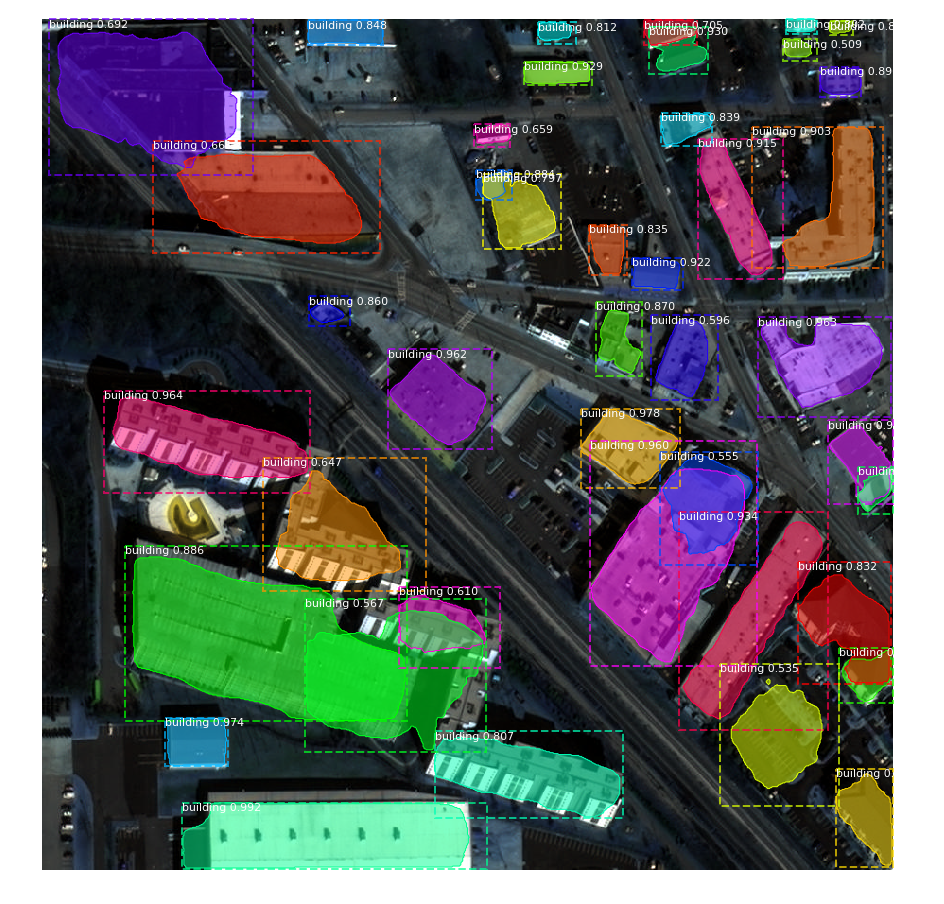

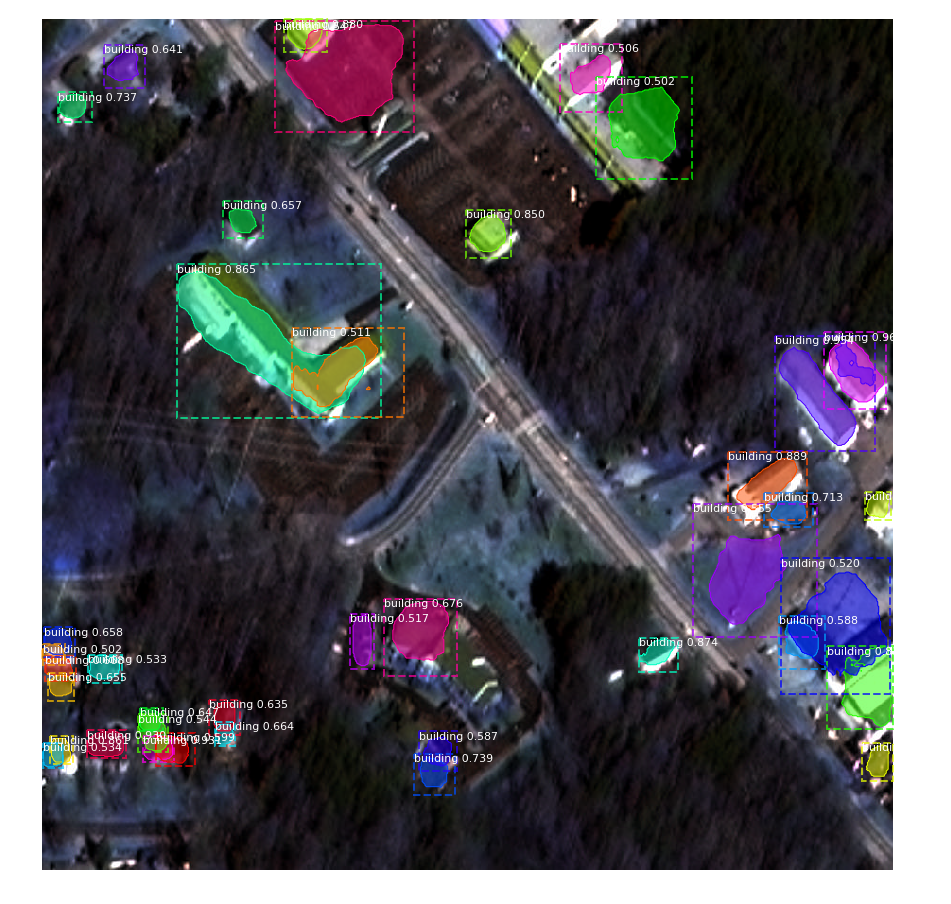

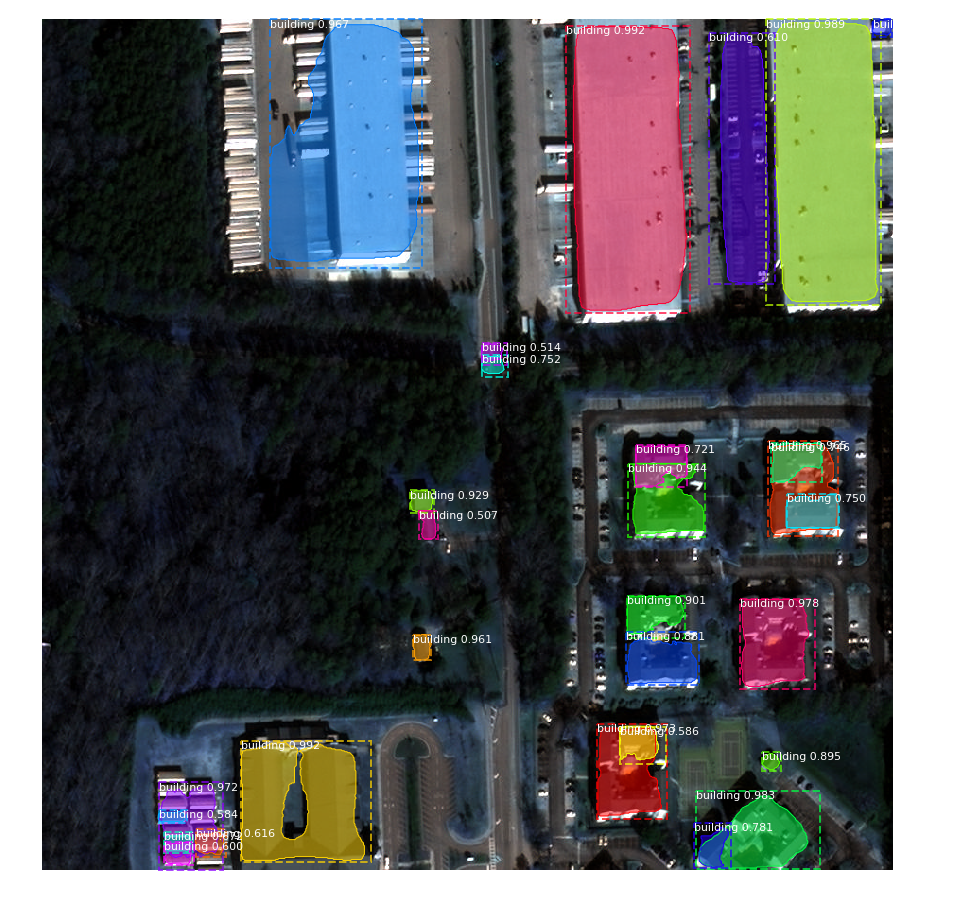

In [13]:
# Load the .pb file
tf.reset_default_graph()
with tf.gfile.GFile(pb_filepath, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
print('Graph loaded\n')


InIMAGE_DIR = "/path/to/test_images"
OutIMAGE_DIR = "/path/to/store_results"


image_names = os.listdir(InIMAGE_DIR) # List of images
images = [os.path.join(InIMAGE_DIR,image) for image in image_names] # List of images with absolute paths

sess = tf.InteractiveSession()

class_names = ["BG","building"]

for i, image in enumerate(images):
    print("Processing:", image_names[i])
    start = time.time()
    
    output_path = os.path.join(OutIMAGE_DIR, image_names[i][:-4] + ".png")
    
    # Load image
    image = imageio.imread(image)
    # remove alpha channel
    image = image[:, :, :3]

    results = detect(sess, [image], inference_config)
    
    r = results[0]
    
    end = time.time()
    
    print("Processing time = {} seconds \n".format(end-start))
    
    # If you want to save the resulting images, uncomment the below two lines
#     fig = visualize.save_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
#     plt.imsave(output_path, fig)
    
    # Display results
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    
print('Done')
